## todo:
KerasTuner Adaption

EarlyStopping callback:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

TensorBoard:
keras.callbacks.TensorBoard(
    log_dir="logs",
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

# Import

In [74]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import pandas as pd
import numpy as np

import json

In [75]:
merged_df = pd.read_csv('protein_expression.csv')
inputed_columns = ['AGID00215',
 'AGID00537',
 'AGID00536',
 'AGID00211',
 'AGID00485',
 'AGID00383',
 'AGID00216',
 'AGID00257',
 'AGID00545',
 'AGID00413',
 'AGID00547',
 'AGID00144']

In [76]:
protein_columns = merged_df.columns.drop(["ajcc_pathologic_stage","vital_status","days_to_death","days_to_last_follow_up","case_submitter_id"])
protein_columns

Index(['AGID00100', 'AGID00111', 'AGID00101', 'AGID00001', 'AGID00002',
       'AGID00003', 'AGID00443', 'AGID00120', 'AGID00004', 'AGID00005',
       ...
       'AGID00349', 'AGID02137', 'AGID00088', 'AGID00089', 'AGID00504',
       'AGID00095', 'AGID02217', 'AGID02210', 'AGID00326', 'AGID00432'],
      dtype='object', length=468)

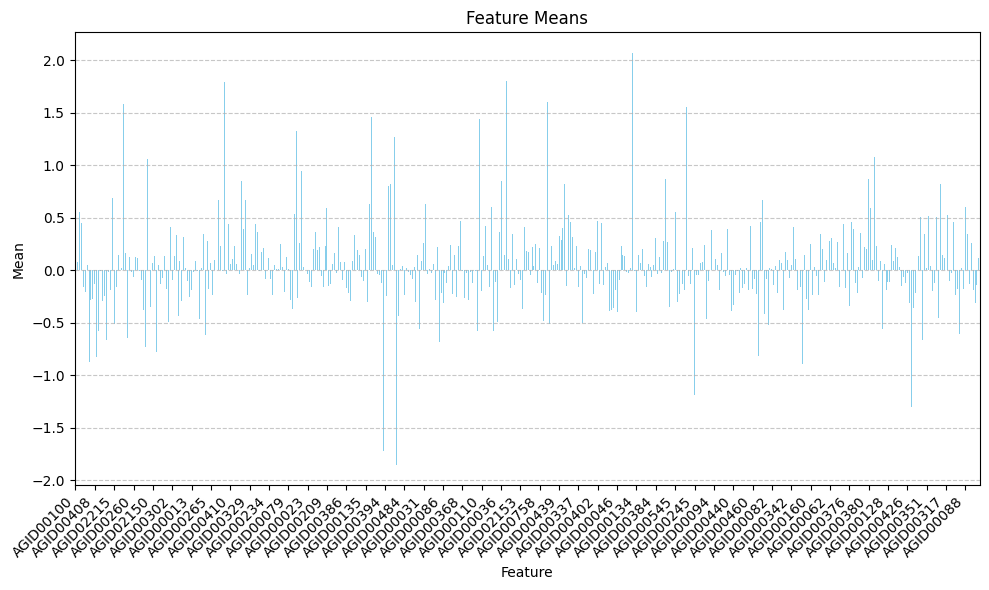

In [77]:
describe_df = merged_df[protein_columns].describe()
row_means = describe_df.loc['mean']

# Plot row means
plt.figure(figsize=(10, 6))
row_means.plot(kind='bar', color='skyblue')
plt.title('Feature Means')
plt.xlabel('Feature')
plt.ylabel('Mean')

plt.xticks(range(0, len(row_means), 10), row_means.index[::10], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

In [78]:
merged_df = merged_df.drop(["ajcc_pathologic_stage","vital_status","days_to_last_follow_up","case_submitter_id"], axis=1)
other = merged_df.columns.drop("days_to_death")

scaler = MinMaxScaler()
merged_df[other] = scaler.fit_transform(merged_df[other])

X_train, X_test, y_train, y_test = train_test_split(merged_df[other], merged_df["days_to_death"],
                                                    train_size=0.8,
                                                    random_state=1)

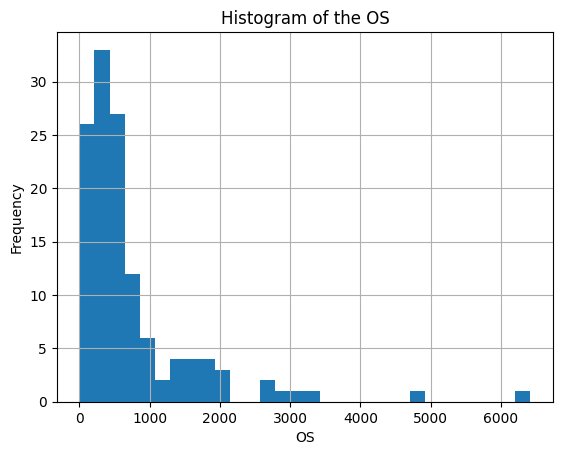

In [79]:
y_train.hist(bins=30) 
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.title('Histogram of the OS')
plt.show()

# AE

In [80]:
class AE():
    def __init__(self,X_train,X_test,y_train,y_test,bottleneck,size,type):
        self.X_train = X_train
        self.X_test = X_test        
        self.y_train = y_train
        self.y_test = y_test
        self.bottleneck = bottleneck
        self.history = None
        self.encoder = None
        self.autoencoder = None
        self.size = size
        self.classifer = None
        self.cv_scores = {}
        self.type = type

    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.h5', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()

    def plot(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss '+ self.size)
        plt.legend()
        plt.show()

    def encode(self):
        try:
            self.autoencoder.load_weights(f'model/{self.type}_{self.size}_best_model.h5')
        except FileNotFoundError:
            self.autoencoder.load_weights(f'model/{self.type}_{self.size}_best_model.keras')

        self.encoded_X_train = self.encoder.predict(self.X_train)
        self.encoded_X_test = self.encoder.predict(self.X_test)
    
    def do_PCA(self,n_components):
        if self.bottleneck == 2:
            # pca = PCA(n_components=n_components)
            # reduced_data = pca.fit_transform(self.encoded_X_test)
            x = self.encoded_X_test[:, 0]
            y = self.encoded_X_test[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('Encoded Data '+self.size)
            plt.xlabel('Encoded Dim 0')
            plt.ylabel('Encoded Dim 1')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
            return
        if n_components ==2:
            pca = PCA(n_components=n_components)
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('PCA of Encoded Data '+self.size)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
        elif n_components ==3:
            pca = PCA(n_components=3)  # Reduce to 3 dimensions
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            z = reduced_data[:, 2]
            fig =plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(x, y, z, c=self.y_test_in_bin, cmap='viridis', depthshade=True)
            ax.set_title('3D PCA of Encoded Data '+self.size)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            plt.colorbar(scatter, label='OS')
            plt.show()

    @staticmethod
    def map_years_to_group(value):
        years = value / 365
        if years <= 1:
            return 0
        elif 1 < years <= 3:
            return 1
        elif 3 < years <= 5:
            return 2
        elif 5 < years <= 10:
            return 3
        elif 10 < years <= 20:
            return 4
        else:  
            return 5
        
    @staticmethod        
    def map_to_binary(category):
        if category >= 4:
            return 1
        else:  
            return 0
        
    def map_y(self):
        self.y_trian_in_category = self.y_train.map(AE.map_years_to_group)
        self.y_test_in_category = self.y_test.map(AE.map_years_to_group)        
        
        self.y_trian_in_bin = self.y_trian_in_category.map(AE.map_to_binary)
        self.y_test_in_bin = self.y_test_in_category.map(AE.map_to_binary)

    def cross_validation_model_selection(self,fold=10):
        classifiers = {
            'LogisticRegression': LogisticRegression(),
            'SVM': SVC(),
            'RandomForest': RandomForestClassifier(),
            'KNN': KNeighborsClassifier(),
            'GradientBoosting': GradientBoostingClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'NaiveBayes': GaussianNB(),
            'DecisionTree': DecisionTreeClassifier(),
            'ExtraTrees': ExtraTreesClassifier(),
            'XGBoost': xgb.XGBClassifier()
        }

        kf = KFold(n_splits=fold)
        best_cv_score = 0


        for name, clf in classifiers.items():
            cv_scores = []
            confusion_matrices = []

            for train_index, test_index in kf.split(self.encoded_X_train):
                X_train, X_test = self.encoded_X_train[train_index], self.encoded_X_train[test_index]
                y_train, y_test = self.y_trian_in_bin.iloc[train_index], self.y_trian_in_bin.iloc[test_index]

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                
                cv_scores.append(accuracy_score(y_test, y_pred))
                confusion_matrices.append(confusion_matrix(y_test, y_pred))

            mean_cv_score = np.mean(cv_scores)
            mean_conf_matrix = np.mean(confusion_matrices, axis=0)

            self.cv_scores[name] = mean_cv_score
            
            print(f"{name} - Mean CV Score: {mean_cv_score}")
            print(f"{name} - Mean Confusion Matrix:\n{mean_conf_matrix}")

            if mean_cv_score > best_cv_score:
                best_cv_score = mean_cv_score
                best_classifier = name

        print(f"Size: {self.size}, Best classifier: {best_classifier}, CV Score: {best_cv_score}")



    def cross_validation_hyperparameter_optimization(self,fold=5):
        pass


    def do_RF(self,binary):
        clf = RandomForestClassifier(n_estimators=100, random_state=0)

        if binary:
            clf.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))

        else:
            clf.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('RF Confusion Matrix '+self.type)
        plt.show()
        self.classifer = clf

    def do_Kmean(self):
        # Number of clusters - assuming you want as many as your known classes
        num_clusters = 2
        # Perform K-means clustering on the PCA output
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(self.encoded_X_test)  # Use your 2D or 3D PCA-reduced data here


        print("Classification Report:")
        print(classification_report(self.y_test_in_bin, cluster_labels))
        conf_mat = confusion_matrix(self.y_test_in_bin, cluster_labels)

        # Plotting the confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('K-mean Confusion Matrix '+self.size)
        plt.show()
        self.classifer = kmeans

    def do_SVM(self,binary):
        svm_classifier = SVC(kernel='linear',random_state=0)
        # Load the best weights into the autoencoder model
        if binary:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.size)
            plt.show()
        else:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))
        
            # Plotting the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_category))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.size)
            plt.show()
        self.classifer = svm_classifier





In [81]:
class WAE(AE):
    def train(self):
    # Number of features in your dataset

    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)
        encoder = Dense(128, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(128, activation='relu')(bottleneck)
        decoder = Dense(256, activation='relu')(decoder)
        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.h5', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()
        
        self.encode()
        self.map_y()       


In [82]:
class DAE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 
    # Number of features in your dataset
        input_layer = Input(shape=(n_features,))
        encoder = Dense(128, activation='relu')(input_layer)

        encoder = Dense(64, activation='relu')(encoder)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        decoder = Dense(128, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.h5', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()    


In [83]:
class WDAE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)
        encoder = Dense(128, activation='relu')(encoder)
        encoder = Dense(64, activation='relu')(encoder)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='SGD', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.h5', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=2000,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()       


In [84]:
class SAE(AE):
    def train(self):

        n_features = len(self.X_train.columns)

        # Define the encoder
        input_layer = Input(shape=(n_features,))
        # Add L1 regularization to encourage sparsity
        encoder = Dense(64, activation='relu', 
                        activity_regularizer=regularizers.l1(1e-6))(input_layer)  # Adjust regularization rate as needed
        encoder = Dense(32, activation='relu', 
                        activity_regularizer=regularizers.l1(1e-6))(encoder)  # Adjust regularization rate as needed

        # Define the bottleneck
        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder = Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        # Callback to save the best model
        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        self.encode()
        self.map_y()



In [85]:
class SWDAE(AE):
    def train(self):

        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu',activity_regularizer=regularizers.l1(1e-4))(input_layer)
        encoder = Dense(128, activation='relu',activity_regularizer=regularizers.l1(1e-4))(encoder)
        encoder = Dense(64, activation='relu',activity_regularizer=regularizers.l1(1e-4))(encoder)
        encoder = Dense(32, activation='relu',activity_regularizer=regularizers.l1(1e-4))(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()    


In [86]:
class AsymmetricAE0(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)

        encoder = Dense(128, activation='relu')(encoder)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


In [87]:
class AsymmetricAE1(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))

        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


In [88]:
class AsymmetricAE2(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))

        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)

        decoder = Dense(64, activation='relu')(decoder)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


In [89]:
class AsymmetricAE3(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))

        encoder = Dense(256, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)

        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


In [90]:
class AsymmetricAE4(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))

        encoder = Dense(256, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)

        decoder = Dense(64, activation='relu')(decoder)


        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


In [91]:
class AsymmetricAE5(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))

        encoder = Dense(256, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)

        decoder = Dense(64, activation='relu')(bottleneck)


        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


In [92]:
class AsymmetricAE6(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))

        encoder = Dense(256, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)



        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='Adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_{self.size}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                            train_size=0.8,
                                            random_state=1)

        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()



        


In [93]:
class RAW(AE):
    def train(self):
        self.map_y()

        self.encoded_X_train = self.X_train.values
        self.encoded_X_test = self.X_test.values

    


        


# Dispatcher

In [94]:
def dispatcher(model,type,min_bottleneck, max_bottleneck,step =1):
    current_size = min_bottleneck
    AEs = []
    results = []
    while current_size <= max_bottleneck:
        name = f"bottleneck_{current_size}"
        AEs.append(model(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = current_size,size = name,type = type))
        current_size += step
    for AE_to_train in AEs:
        AE_to_train.train()
        AE_to_train.cross_validation_model_selection()
        results.append({f"{AE_to_train.type} {AE_to_train.size}": AE_to_train.cv_scores})
    
    output = json.dumps(results)
    with open(f"output/{type}_model_output.json","w") as file:
        file.write(output)
    return
    

In [95]:
# dispatcher(AE,"AE",6,48)

In [96]:
# dispatcher(WAE,"WAE",6,48)

In [97]:
# dispatcher(DAE,"DAE",6,48)

In [98]:
# dispatcher(WDAE,"WDAE",6,48)

In [99]:
# dispatcher(SAE,"SAE",6,48)

In [100]:
# dispatcher(SWDAE,"SWDAE",6,48)

In [101]:
# dispatcher(AsymmetricAE0,"AsymmetricAE0",6,48)


In [102]:
# dispatcher(AsymmetricAE1,"AsymmetricAE1",6,48)

In [103]:
# dispatcher(AsymmetricAE2,"AsymmetricAE2",6,48)

In [104]:
# dispatcher(AsymmetricAE3,"AsymmetricAE3",6,48)

In [105]:
# dispatcher(AsymmetricAE4,"AsymmetricAE4",6,48)

In [106]:
# dispatcher(AsymmetricAE5,"AsymmetricAE5",6,48)

In [107]:
# dispatcher(AsymmetricAE6,"AsymmetricAE6",6,48)


In [108]:
# dispatcher(RAW,"RAW",6,48)

# Performance

In [109]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [110]:
def print_statistics(data,filename):
    # overall_means = {classifier: np.mean(list(values.values())) for classifier, values in data.items()}



    # Calculate statistics for each classifier
    statistics = {}
    for classifier, values in data.items():
        values_list = list(values.values())
        statistics[classifier] = {
            'Mean': np.mean(values_list),
            'Standard Deviation': np.std(values_list),
            # 'Minimum': np.min(values_list),
            'Maximum': np.max(values_list),
            # '25th Percentile': np.percentile(values_list, 25),
            # '50th Percentile (Median)': np.median(values_list),
            # '75th Percentile': np.percentile(values_list, 75)
        }

    # Convert statistics dictionary to a DataFrame for better visualization
    stats_df = pd.DataFrame(statistics).T
    # overall_mean = np.mean(stats_df["Mean"])
    print(f"--------------------- {filename} ----------------------")
    # print(f"Overall_mean {overall_means}")
    print(stats_df)

In [111]:

# Directory containing the JSON files
directory = 'output'


# List of classifiers to consider
classifiers = ["LogisticRegression", "SVM", "RandomForest", "KNN", "GradientBoosting", 
               "AdaBoost", "NaiveBayes", "DecisionTree", "ExtraTrees", "XGBoost"]

# Function to plot data from a single JSON file
def plot_single_file(data, title):
    plt.figure(figsize=(14, 8))
    for classifier, bottlenecks in data.items():
        x = sorted(bottlenecks.keys())
        y = [bottlenecks[size] for size in x]
        plt.plot(x, y, label=classifier)
        max_index = y.index(max(y))
        plt.plot(x[max_index], y[max_index], 'ro')  # Mark the highest point
        plt.text(x[max_index], y[max_index], f'{y[max_index]:.2f}', fontsize=9, ha='right')
    plt.xlabel('Bottleneck Size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Initialize a list to hold data for each JSON file
all_data = []

# Read and process each JSON file
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r') as file:
            json_data = json.load(file)
            data = {classifier: {} for classifier in classifiers}
            for entry in json_data:
                for bottleneck, scores in entry.items():
                    size = int(bottleneck.split('_')[-1])
                    for classifier, score in scores.items():
                        data[classifier][size] = score
                        
            print_statistics(data,filename)
            # plot_single_file(data, f'Performance from {filename}')
            all_data.append(data)

# # Plotting combined graph
# plt.figure(figsize=(14, 8))
# for i, data in enumerate(all_data):
#     for classifier, bottlenecks in data.items():
#         x = sorted(bottlenecks.keys())
#         y = [bottlenecks[size] for size in x]
#         plt.plot(x, y, label=f'{classifier} (File {i+1})')
#         max_index = y.index(max(y))
#         plt.plot(x[max_index], y[max_index], 'ro')  # Mark the highest point
#         plt.text(x[max_index], y[max_index], f'{y[max_index]:.2f}', fontsize=9, ha='right')

# plt.xlabel('Bottleneck Size')
# plt.ylabel('Accuracy')
# plt.title('Combined Classifier Performance by Bottleneck Size')
# plt.legend()
# plt.grid(True)
# plt.show()

--------------------- WDAE_model_output.json ----------------------
                        Mean  Standard Deviation   Maximum
LogisticRegression  0.561553            0.032962  0.621538
SVM                 0.574326            0.031079  0.648462
RandomForest        0.588490            0.029148  0.660308
KNN                 0.581703            0.027113  0.641077
GradientBoosting    0.573496            0.034066  0.652615
AdaBoost            0.564386            0.039860  0.660462
NaiveBayes          0.532937            0.026126  0.605846
DecisionTree        0.549170            0.029699  0.606308
ExtraTrees          0.594533            0.027376  0.645077
XGBoost             0.574354            0.036256  0.648462
--------------------- SWDAE_model_output.json ----------------------
                        Mean  Standard Deviation   Maximum
LogisticRegression  0.475231            0.000000  0.475231
SVM                 0.475231            0.000000  0.475231
RandomForest        0.475488         

## Obtained a record 0f 0.69 at AsymmetricAE4 for RandomForest and XGBoost of bottle neck 36, then applying hyperparameter optimize

In [112]:
import optuna
from tensorflow.keras.models import load_model

In [113]:

# Load the entire autoencoder model
autoencoder = load_model('model/AsymmetricAE4_bottleneck_36_best_model.keras')

# Print the summary to see layer names
print(autoencoder.summary())


Model: "functional_1593"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_797 (InputLayer)    │ (None, 468)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5813 (Dense)              │ (None, 256)            │       120,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5814 (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5815 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5816 (Dense)              │ (None, 36)             │         1,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5817 (Dense)              │ (None, 32)             │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5818 (Dense)              │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5819 (Dense)              │ (None, 468)            │        30,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,490 (1.99 MB)

 Trainable params: 173,496 (677.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 346,994 (1.32 MB)

None


In [127]:
class OptimizedAsymmetricAE(AsymmetricAE4):
    def __init__(self, X_train, X_test, y_train, y_test, bottleneck = 36, size = "bottleneck_36", type="AsymmetricAE4"):
        super().__init__(X_train, X_test, y_train, y_test, bottleneck, size, type)
    
    def encode(self):
        self.autoencoder = load_model('model/AsymmetricAE4_bottleneck_36_best_model.keras')
        self.encoder = Model(inputs=autoencoder.input,
                      outputs=autoencoder.get_layer('dense_5816').output)

        self.encoded_X_train = self.encoder.predict(self.X_train)
        self.encoded_X_test = self.encoder.predict(self.X_test)
    def cross_validation_hyperparameter_optimization(self):
        SVM_study = optuna.create_study(direction='maximize')
        SVM_study.optimize(self.SVM_objective, n_trials=4000)
        best_svm_trial = SVM_study.best_trial
        print("SVM Result")
        print("Best hyperparameters: ", best_svm_trial.params)
        print("Best accuracy: ", best_svm_trial.value)


        RF_study = optuna.create_study(direction='maximize')
        RF_study.optimize(self.RF_objective, n_trials=4000)
        best_trial = RF_study.best_trial
        print("RF Result")
        print("Best hyperparameters: ", best_trial.params)
        print("Best accuracy: ", best_trial.value)



        XGBoost_study = optuna.create_study(direction='maximize')
        XGBoost_study.optimize(self.XGBoost_objective, n_trials=200)
        best_trial = XGBoost_study.best_trial
        print("XGBoost Result")
        print("Best hyperparameters: ", best_trial.params)
        print("Best accuracy: ", best_trial.value)


    def RF_objective(self,trial):
        # Load data

        # Suggest hyperparameters
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 800),
            'max_depth': trial.suggest_int('max_depth', 2, 128),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
            'max_features': trial.suggest_categorical('max_features', [1,600])
        }

        # Create the model
        clf = RandomForestClassifier(**param)
        
        # Evaluate the model using cross-validation
        score = cross_val_score(clf, self.encoded_X_train, self.y_trian_in_bin, n_jobs=-1, cv=3, scoring='accuracy')
        accuracy = score.mean()
        return accuracy

    def SVM_objective(self, trial):
        # Suggest hyperparameters
        param = {
            'C': trial.suggest_loguniform('C', 1e-3, 1e3),
            'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e1),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        }

        # Create the SVM model
        clf = SVC(**param)
        
        # Evaluate the model using cross-validation
        score = cross_val_score(clf, self.encoded_X_train, self.y_trian_in_bin, n_jobs=-1, cv=3, scoring='accuracy')
        accuracy = score.mean()
        return accuracy
    
    def XGBoost_objective(self,trial):
        
        # Suggest hyperparameters
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'tree_method': 'hist',  # faster with large datasets
            'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
            'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        }

        if param['booster'] == 'dart':
            param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
            param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
            param['rate_drop'] = trial.suggest_float('rate_drop', 0.0, 0.3)
            param['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.3)
        
        # Create the model
        model = xgb.XGBClassifier(**param)
        
        # Evaluate the model using cross-validation
        score = cross_val_score(model, self.encoded_X_train, self.y_trian_in_bin, n_jobs=-1, cv=3, scoring='accuracy')
        accuracy = score.mean()
        return accuracy

In [128]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [129]:
AE_to_optimize = OptimizedAsymmetricAE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
AE_to_optimize.encode()
AE_to_optimize.map_y()
AE_to_optimize.cross_validation_hyperparameter_optimization()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


[I 2024-07-02 13:25:55,226] A new study created in memory with name: no-name-78e039c2-29b9-48d6-82ea-a240f0ffed9b
[I 2024-07-02 13:25:57,015] Trial 0 finished with value: 0.5134990644212777 and parameters: {'C': 0.11492260930519822, 'gamma': 1.1932473066519187, 'kernel': 'rbf'}. Best is trial 0 with value: 0.5134990644212777.
[I 2024-07-02 13:25:57,443] Trial 1 finished with value: 0.6064332174997773 and parameters: {'C': 19.91333068895495, 'gamma': 0.003825011967128884, 'kernel': 'rbf'}. Best is trial 1 with value: 0.6064332174997773.
[I 2024-07-02 13:25:57,471] Trial 2 finished with value: 0.6101309810211173 and parameters: {'C': 0.8632945545119872, 'gamma': 0.20088363389776792, 'kernel': 'rbf'}. Best is trial 2 with value: 0.6101309810211173.
[I 2024-07-02 13:25:57,547] Trial 3 finished with value: 0.586875167067629 and parameters: {'C': 0.0015524614824807997, 'gamma': 0.6718506340524171, 'kernel': 'poly'}. Best is trial 2 with value: 0.6101309810211173.
[I 2024-07-02 13:25:57,632] 

SVM Result
Best hyperparameters:  {'C': 0.7268111869292551, 'gamma': 0.1067078324054298, 'kernel': 'rbf'}
Best accuracy:  0.652677537200392


[I 2024-07-02 13:28:27,246] Trial 1 finished with value: 0.6564198520894592 and parameters: {'n_estimators': 542, 'max_depth': 113, 'min_samples_split': 14, 'min_samples_leaf': 22, 'max_features': 600}. Best is trial 1 with value: 0.6564198520894592.
[I 2024-07-02 13:28:27,683] Trial 2 finished with value: 0.6642163414416822 and parameters: {'n_estimators': 423, 'max_depth': 92, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 600}. Best is trial 2 with value: 0.6642163414416822.
[I 2024-07-02 13:28:27,919] Trial 3 finished with value: 0.6063886661320502 and parameters: {'n_estimators': 428, 'max_depth': 98, 'min_samples_split': 7, 'min_samples_leaf': 27, 'max_features': 1}. Best is trial 2 with value: 0.6642163414416822.
[I 2024-07-02 13:28:28,574] Trial 4 finished with value: 0.6758442484184264 and parameters: {'n_estimators': 531, 'max_depth': 119, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 600}. Best is trial 4 with value: 0.6758442484184264.
[I 

RF Result
Best hyperparameters:  {'n_estimators': 799, 'max_depth': 46, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 600}
Best accuracy:  0.7067183462532299


[I 2024-07-02 14:12:44,978] Trial 1 finished with value: 0.6603849238171612 and parameters: {'booster': 'dart', 'lambda': 0.497882249186514, 'alpha': 1.9950396179063143e-08, 'subsample': 0.5802893961217344, 'colsample_bytree': 0.5452088759096798, 'learning_rate': 0.03154699260328236, 'n_estimators': 139, 'max_depth': 8, 'min_child_weight': 4, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.1572197930469671, 'skip_drop': 0.206452594800142}. Best is trial 1 with value: 0.6603849238171612.
[I 2024-07-02 14:12:50,384] Trial 2 finished with value: 0.6332085895036977 and parameters: {'booster': 'dart', 'lambda': 0.2919896270935133, 'alpha': 7.737949399703875e-06, 'subsample': 0.8376501360328397, 'colsample_bytree': 0.7631092683303811, 'learning_rate': 0.01113941424550333, 'n_estimators': 466, 'max_depth': 5, 'min_child_weight': 4, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00523517372783957, 'skip_drop': 0.19336814946079517}. Best is trial 1 with

XGBoost Result
Best hyperparameters:  {'booster': 'dart', 'lambda': 0.03001624853092259, 'alpha': 0.00037348639470266527, 'subsample': 0.9990741911594107, 'colsample_bytree': 0.9269333152825322, 'learning_rate': 0.02182299373664868, 'n_estimators': 959, 'max_depth': 6, 'min_child_weight': 8, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.27833283084012433, 'skip_drop': 0.05705040277168033}
Best accuracy:  0.6835516350351956


RF Result
Best hyperparameters:  {'n_estimators': 799, 'max_depth': 46, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 600}
Best accuracy:  0.7067183462532299

# Hyperparameter Optimization


# Resources Investigation:

ICGC:
https://dcc.icgc.org/repositories?filters=%7B%22file%22:%7B%20%22projectCode%22:%7B%22is%22:%5B%22HNSC-US%22%5D%7D%7D%7D

 Data Type
 SSM  2,126
 Aligned Reads  2,037
 Clinical Data  453
 Biospecimen Data  448
 StSM  223
 SGV  132
 CNSM  88
 StGV  88

TCPA:
https://www.tcpaportal.org/tcpa/download.html

TCGA of 2018, with L4(normalized across RPPA batches therefore enable pan-cancer)

PDC:
https://proteomic.datacommons.cancer.gov/pdc/browse
3 studies, but Mass Spectrum not RPPA, therefore only contains Peptide result. do have clinincal though

HNSCC PDX: 
https://aacrjournals.org/mcr/article/14/3/278/89624/Proteomic-Characterization-of-Head-and-Neck-Cancer
RPPA, but on mention how to acess and probabaly wound not have clinical since the read from transplated rats.

HAP: Reference RNA and protein from healthy samples:
https://www.proteinatlas.org/about/download

Pride:Full MS sets
https://www.ebi.ac.uk/pride/archive?keyword=HNSCC,RPPA&sortDirection=DESC&page=0&pageSize=20

Paper HNSCC: RPPA but only target 60 specific protein
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070553/

GEO: Some Protein profiling by protein array (RPPA), no HNSCC
https://www.ncbi.nlm.nih.gov/geo/browse/

ArraryExpress: RPPA for GBM, lung cancer, breast cancer
https://www.ebi.ac.uk/biostudies/arrayexpress/studies?query=RPPA

FANTOM6 Experiment Index: RNA-Seq
https://fantom.gsc.riken.jp/6/experiment_index/#/

Resources index: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6971871/